# Overview

To facilitate rapid prototyping, the Dune Python bindings
provide Python classes for all the core interfaces of Dune. This makes
it easy to develop algorithms directly in Python which go beyond what is
available through the Dune-Fem discretization module. This is especially
of interest for pre- and postprocessing part of the overall simulation
package. While most interface methods from the Dune-Fem package are
high level, i.e., computationally expensive, many of the core Dune
interface methods are not, i.e., the methods for computing the geometric
representation of an element or the methods required to iterate over a
grid. Consequently, depending on the requirements of the developed code
parts, using the Dune core interfaces through Python could incur a too high
hit on the performance of the code. Since the exported Python interfaces
are very close to the original Dune C++ interfaces, transferring a Python
prototype of the algorithm to C++ is mostly straightforward. A just in
time compilation utility available in Dune-Python makes it then very easy
to use these [C++ algorithms](cpp.rst) from within Python.

In the following we briefly introduce the most important parts of the
Dune core interface

.. index::
   pair: Overview; Dense Vectors

.. index::
   pair: Overview; Geometries

# Dense Vectors and the Geometry Classes
We start with a quick survey of Dune-Common and Dune-Geometry modules.
The core module Dune-Common provides some classes for dense linear algebra.

In [1]:
import time, numpy, sys
import matplotlib.pyplot as pyplot
import dune.fem

from dune.common import FieldVector
x = FieldVector([0.25,0.25,0.25])
print(x)
print(numpy.array(x))

(0.250000, 0.250000, 0.250000)
[0.25 0.25 0.25]


The `FieldVector` and `FieldMatrix` classes are heavily used in the grid
geometry realizations. The conceptional basis for these geometries is
provided by Dune-Geometry, providing, for example, reference elements and
quadrature rules.

In [2]:
import dune.geometry
geometryType = dune.geometry.simplex(2)
referenceElement = dune.geometry.referenceElement(geometryType)
print("\t".join(str(c) for c in referenceElement.corners))

for p in dune.geometry.quadratureRule(geometryType, 3):
    print("position:",p.position,f"({type(p.position)})", "weight:",p.weight,f"({type(p.weight)})")

(0.000000, 0.000000)	(1.000000, 0.000000)	(0.000000, 1.000000)
position: (0.333333, 0.333333) (<class 'dune.common._common.FieldVector_double_2'>) weight: -0.28125 (<class 'float'>)
position: (0.600000, 0.200000) (<class 'dune.common._common.FieldVector_double_2'>) weight: 0.2604166666666667 (<class 'float'>)
position: (0.200000, 0.600000) (<class 'dune.common._common.FieldVector_double_2'>) weight: 0.2604166666666667 (<class 'float'>)
position: (0.200000, 0.200000) (<class 'dune.common._common.FieldVector_double_2'>) weight: 0.2604166666666667 (<class 'float'>)


We can also obtain all weights and points stored in numpy arrays which
can be useful to vectorize the computation of quadratures:

In [3]:
points,weights = dune.geometry.quadratureRule(geometryType, 3).get()
print("quadrature points:",points,f"({type(points)},{points.shape})")
print("quadrature weights:",weights,f"({type(weights)},{weights.shape})")

quadrature points: [[0.33333333 0.6        0.2        0.2       ]
 [0.33333333 0.2        0.6        0.2       ]] (<class 'numpy.ndarray'>,(2, 4))
quadrature weights: [-0.28125     0.26041667  0.26041667  0.26041667] (<class 'numpy.ndarray'>,(4,))


.. index::
   pair: Grid construction; Structured grids

# Grid Construction and Basic Interface
We now move on to the Dune-Grid module. First let us discuss different
possibilities of constructing a grid.

#### Structured grids
We start with a structured grid. We saw in previous section the use of
`dune.grid.structuredGrid` which is just a shortcut for setting up a
Cartesian grid based on the `yaspGrid` grid manager which is part of
`dune.grid`.

In [4]:
from dune.grid import cartesianDomain, yaspGrid
domain = cartesianDomain([0, 0], [1, 0.25], [15, 4])
yaspView = yaspGrid(domain)

Let's visualize the grid and then globally refine it once

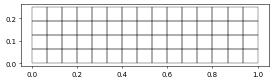

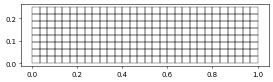

In [5]:
yaspView.plot()
yaspView.hierarchicalGrid.globalRefine()
yaspView.plot()

The `dune.alugrid` module provides 2d and 3d unstructured grids (both
triangle and cubes). We can construct a triangle grid, visualize, and
refine it in exactly the same way as the structured grid used above.
We use `dune.alugrid.aluConformGrid` which uses newest vertex bisection
to refine the grid. So one step of refinement only reduces the grid width
by a factor of $\sqrt2$. We we need two steps to half the grid width:

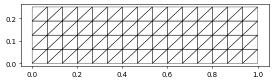

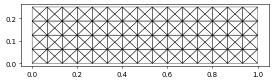

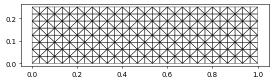

In [6]:
from dune.alugrid import aluConformGrid
aluView = aluConformGrid(domain)
aluView.plot()
aluView.hierarchicalGrid.globalRefine()
aluView.plot()
aluView.hierarchicalGrid.globalRefine()
aluView.plot()

We can also provide the number of levels to refine to the `globalRefine`
method:

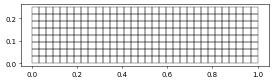

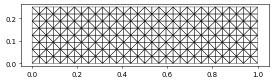

In [7]:
domain = cartesianDomain([0, 0], [1, 0.25], [8, 2])
yaspView = yaspGrid(domain)
aluView = aluConformGrid(domain)

yaspView.hierarchicalGrid.globalRefine(2)
yaspView.plot()
aluView.hierarchicalGrid.globalRefine(4)
aluView.plot()

The `dune.grid.yaspGrid` grid manager also provides the option to construct
tensor product grid. For a 2d grid one needs to provide a vector
of x-coordinates $x=(x_i)$ and y-coordinates $y=(y_j)$
resulting in a grid with points $(x_i,y_j)$:

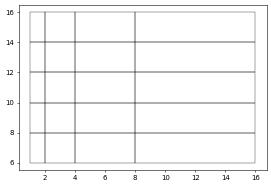

In [8]:
from dune.grid import tensorProductCoordinates
cst = dune.grid.tensorProductCoordinates([[1,2,4,8,16],[6,8,10,12,14,16]])
yaspView = dune.grid.yaspGrid(cst)
yaspView.plot()

.. index:: Grid construction; Dictionaries

#### Unstructured grids
General unstructured grids can be constructed by providing a dictionary containing vertex coordinate
and element connectivity

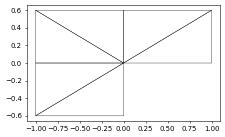

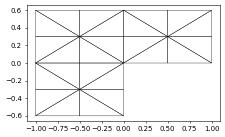

In [9]:
vertices = [(0,0), (1,0), (1,0.6), (0,0.6), (-1,0.6), (-1,0), (-1,-0.6), (0,-0.6)]
triangles = [(2,0,1), (0,2,3), (4,0,3), (0,4,5), (6,0,5), (0,6,7)]
aluView = aluConformGrid({"vertices": vertices, "simplices": triangles})
aluView.plot(figsize=(5,5))
aluView.hierarchicalGrid.globalRefine(2)
aluView.plot(figsize=(5,5))


An unstructured grid can also be constructed from a file.
Currently [gmsh and DGF](othergrids_nb.ipynb) are supported.

.. index:: Adaptation; h-refinement

#### Local grid adaptivity
In addition to global refinement we can also pre process the grid by
marking a subset of elements for local refinement.

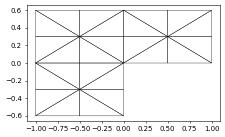

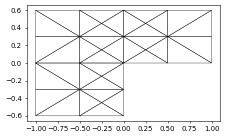

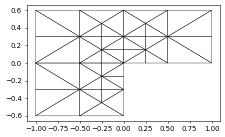

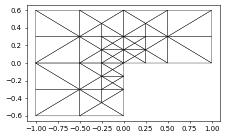

In [10]:
from dune.grid import Marker
aluView.plot(figsize=(5,5))
for i in range(1,4):
    def mark(e):
        x = e.geometry.center
        return Marker.refine if x.two_norm < 0.64**i else Marker.keep
    aluView.hierarchicalGrid.adapt(mark)
    aluView.plot(figsize=(5,5))

from dune.alugrid import aluSimplexGrid
vertices = aluView.coordinates()
triangles = [aluView.indexSet.subIndices(e, 2) for e in aluView.elements]
aluView = aluSimplexGrid({"vertices": vertices, "simplices": triangles})

.. tip:: If discrete functions based on the `dune.fem` spaces have been
   constructed before local or global grid refinement is performed, the
   degree of freedom (dof) vectors will be resized but the data will be
   lost. Use `dune.fem.adapt` and `dune.fem.globalRefine` if data is
   supposed to be retained during grid modification. This is described in
   detail in the section on
   [dynamic grid modification](gridviews_and_adaptivity.rst#Dynamic-Local-Grid-Refinement-and-Coarsening).

.. index::
   pair: Overview; Iterators

### Basic information and iterators
We next discuss how to retrieve basic information from a constructed grid
and iterate over its entities (i.e., elements, faces, edges, vertices, etc.).

In [11]:
vertices = [(0,0), (1,0), (1,1), (0,1)]
triangles = [(2,0,1), (0,2,3)]
unitSquare = aluSimplexGrid({"vertices": vertices, "simplices": triangles})
print(unitSquare.size(0),"elements and",unitSquare.size(2),"vertices")

for codim in range(0, unitSquare.dimension+1):
    for entity in unitSquare.entities(codim):
        print(", ".join(str(c) for c in entity.geometry.corners))

for edge in unitSquare.edges:
    print(", ".join(str(c) for c in edge.geometry.corners))

2 elements and 4 vertices
(0.000000, 0.000000), (0.000000, 1.000000), (1.000000, 1.000000)
(1.000000, 1.000000), (1.000000, 0.000000), (0.000000, 0.000000)
(0.000000, 0.000000), (1.000000, 0.000000)
(0.000000, 0.000000), (1.000000, 1.000000)
(0.000000, 0.000000), (0.000000, 1.000000)
(1.000000, 0.000000), (1.000000, 1.000000)
(1.000000, 1.000000), (0.000000, 1.000000)
(0.000000, 0.000000)
(1.000000, 0.000000)
(1.000000, 1.000000)
(0.000000, 1.000000)
(0.000000, 0.000000), (1.000000, 0.000000)
(0.000000, 0.000000), (1.000000, 1.000000)
(0.000000, 0.000000), (0.000000, 1.000000)
(1.000000, 0.000000), (1.000000, 1.000000)
(1.000000, 1.000000), (0.000000, 1.000000)


In the above we have used the geometry method on the entity which
provides the geometric mapping between the reference element of the
entity and it's position in physical space. We have used the corners
method to retrieve corners of the entity. Other properties and methods
are available to provide volume or the integration element needed to
compute quadratures of a grid function over the element -
which is discussed in the next section.


.. index::
   pair: Functions; Grid Functions

# Using grid functions
This is a fundamental concept in any grid based discretization package.
These are functions that can be evaluated given an entity in the grid and
a local coordinate within the reference element of that entity.

.. tip:: in the following we will use the `gridFunction` decorator
   provided by `dune.fem`. A very similar decorator is also available in
   `dune.grid` but the latter does not provide the option to use the grid
   functions in ufl expressions.

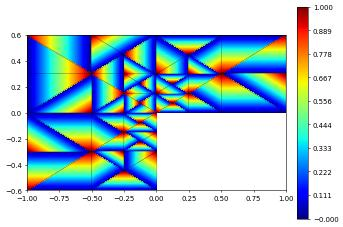

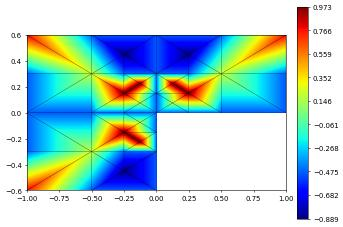

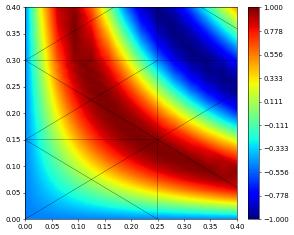

In [12]:
@dune.fem.function.gridFunction(aluView, name="cos", order=3)
def f(x):
    return numpy.cos(2.*numpy.pi/(0.3+abs(x[0]*x[1])))

@dune.fem.function.gridFunction(aluView, name="hat0", order=3)
def hat0(element,hatx):
    return 1-hatx[0]-hatx[1]

hatx = FieldVector([1./3., 1./3.])
maxValue = max(f(e, hatx) for e in f.gridView.elements)

maxValue = max(f(e.geometry.toGlobal(hatx)) for e in f.gridView.elements)

hat0.plot()
f.plot()
f.plot(level=3,xlim=[0,0.4], ylim=[0,0.4])

.. index::
   pair: Quadratures; Simple Quadrature Rules

We can now use the quadrature rules discuss at the beginning of this
chapter to compute the integral over each element of the grid function.

In [13]:
from dune.geometry import quadratureRules
rules = quadratureRules(5)
integral = 0
for e in aluView.elements:
    geo = e.geometry
    for qp in rules(e.type):
        x,w = qp.position, qp.weight
        integral += f(e,x)*w*geo.integrationElement(x)
print("integral of function 'f':",integral)

integral of function 'f': 0.07942992585030195


There are some approach available to improve the efficiency of the
computation of integrals since this is an important component of many
grid based schemes. Especially, using vectorization can greatly reduce
the complexity of the above loop:

In [14]:
integral = 0
for e in aluView.elements:
    # obtain numpy arrays containing the points and weights and then call
    # required functions using these vectors with requiring a loop
    points, weights = rules(e.type).get()
    ies = e.geometry.integrationElement(points)
    values = f(e,points)
    integral += numpy.sum(values*ies*weights,axis=-1)
print("integral of function 'f':",integral)

integral of function 'f': 0.07942992585030195


Now a vector valued function

In [15]:
# an easy case
dimR = 2
@dune.fem.function.gridFunction(aluView, name="g", order=3)
def g(x):
    return [numpy.cos(2.*numpy.pi/(0.3+abs(x[0]*x[1])))]*dimR
# bit more complex to code
@dune.fem.function.gridFunction(aluView, name="g", order=3)
def g(x):
    if type(x[0]) is float:
        return [numpy.cos(2.*numpy.pi/(0.3+abs(x[0]*x[1]))),1]
    else:
        return [numpy.cos(2.*numpy.pi/(0.3+abs(x[0]*x[1]))),[1]*len(x[0])]
integral = g.dimRange*[0]
for e in aluView.elements:
    # obtain numpy arrays containing the points and weights and then call
    # required functions using these vectors with requiring a loop
    points, weights = rules(e.type).get()
    ies = e.geometry.integrationElement(points)
    values = g(e,points)
    integral += numpy.sum(values*ies*weights,axis=-1)
print("integral of function 'g':",integral)

integral of function 'g': [0.07942993 1.8       ]


.. index::
   triple: Algorithm; C++; User defined code

# Importing user defined C++ code
To achieve close to native efficiency the Python prototype
can be easily reimplemented as a C++ function and the `algorithm` module
used for just in time compilation. This is discussed in a later section
based on [some examples](cpp.rst).

.. index:: Grids; Attaching data

.. index::
   pair: Overview; Dof Mappers

# Attaching Data to the Grid
To attach data to the entities in a grid, each Dune grid has an
`IndexSet` which provides a consecutive, zero starting integer for the
set of entities of a given geometry type, i.e., entities sharing the same
reference element, like all triangles or all cubes. This can be used to attach
data to these entities stored in random access containers like
`numpy` arrays. To simplify the process further a `mapper` can be used
which is initialized with the data layout, i.e., the number of degrees of
freedom that is supposed to be attached to every entity with a given
geometry type.

In the following we first construct a mapper for a 2d cube grid
attaching 2 dofs to each
element (codimension 0), 4 to each edge (codimension 1), and 3 to each
vertex (codimension 2):

In [16]:
layout = [2,4,3]
mapper = unitSquare.mapper([2, 4, 3])
print( mapper.size, sum([layout[c]*unitSquare.size(c) for c in range(3)]) )

36 36


We can also use the reference element types from `dune.geometry` to
define the layout

In [17]:
layout = {dune.geometry.quadrilateral: 4, dune.geometry.triangle: 1}
mapper = unitSquare.mapper(layout)

Finally here is an example of using the mapper to attach one degree of
freedom per vertex and using that to define a piecewise linear Lagrange
interpolation:

In [18]:
def interpolate(grid):
    mapper = grid.mapper({dune.geometry.vertex: 1})
    data = numpy.zeros(mapper.size)
    for v in grid.vertices:
        data[mapper.index(v)] = f(v.geometry.center)
    return mapper, data

mapper, data = interpolate(aluView)
@dune.fem.function.gridFunction(aluView, name="p12d", order=1)
def p12dEvaluate(e, x):
    bary = 1-x[0]-x[1], x[0], x[1]
    idx = mapper.subIndices(e, 2)
    return sum(b * data[i] for b, i in zip(bary, idx))

We can use a grid function to compute the error of the Lagrange
interpolation at the barycenter of each triangle:

In [19]:
@dune.fem.function.gridFunction(aluView, name="error", order=3)
def error(e, x):
    return abs(p12dEvaluate(e, x)-f(e, x))
hatx = FieldVector([1./3., 1./3.])
print(max(error(e, hatx) for e in aluView.elements))

1.6026566867981322


.. tip:: the mapper describe here provides a slightly extended interface
   compared to the [mappers available from discrete spaces](concepts_nb.ipynb#Discrete-Spaces)
   in `dune.fem`. While the mappers from the grid provide methods like `subIndices` and
   similar the mapper from the space only provide a method to obtain all
   indices attached to a given (codimension 0) entity. This method
   is also available in the mappers from the grid.

In [20]:
for i,e in enumerate(aluView.elements):
    print(mapper(e))
    if i==4: break

[0 1 2]
[2 3 0]
[0 4 5]
[3 4 0]
[6 7 0]


.. index::
   pair: Grids; Plotting

.. index::
   pair: I/O; Plotting

# Output of Grid and Visualization of Data
We already used `matplotlib` to plot the grid and grid functions. For more
flexible plotting Dune relies on `vtk` and it easy to write suitable files.

#### Matplotlib
We have seen many examples already of using matplotlib to show the grid
and grid functions. The most straightforward way is to use the `plot`
method. We first show three plots using matplotlib

.. tip:: the `plot` method will only work on 1d or 2d grids.

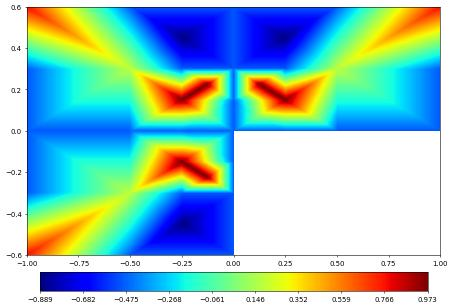

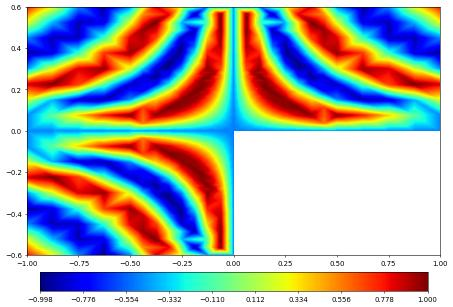

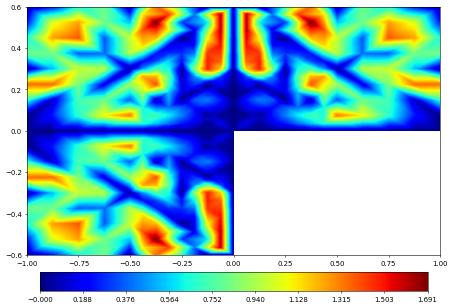

In [21]:
p12dEvaluate.plot(figsize=(9,9), gridLines=None, colorbar="horizontal")
f.plot(level=2, figsize=(9,9), gridLines=None, colorbar="horizontal")
error.plot(level=2, figsize=(9,9), gridLines=None, colorbar="horizontal")

#### Paraview (vtu/vtk files)
Now we write out vtu files and use ``pvpython`` to prduce similar but 3d
plots of the same functions

In [22]:
pd = {"exact": f, "discrete": p12dEvaluate, "error": error}
aluView.writeVTK("interpolation", pointdata=pd)

aluView.writeVTK("interpolation_subsampled", subsampling=2, pointdata=pd)

Here are pngs generated with paraview from the above output:
The discrete interpolation
![interpolation](figures/interpolation_discrete.png)
A zoom in
![exact solution](figures/interpolation_exact.png)
The interpolation error on the subsampled grid
![interpolation error](figures/interpolation_error.png)

#### Mayavi
Mayavi can also be used to plot grid function in Python. This approach
relies on methods to extract `numpy` representations of the grid data
structure and values of a given grid function.

In [23]:
level = 3
triangulation = f.gridView.triangulation(level)
z = f.pointData(level)[:,0]
try:
    from mayavi import mlab
    from mayavi.tools.notebook import display
    mlab.init_notebook("png")
    mlab.figure(bgcolor = (1,1,1))
    s = mlab.triangular_mesh(triangulation.x, triangulation.y, z*0.5,
                             triangulation.triangles)
    display( s )
    # mlab.savefig("mayavi.png", size=(400,300))
    mlab.close(all=True)
except (ImportError, ModuleNotFoundError):
    print("mayavi module not found so not rendering plot - ignored")
    pass

mayavi module not found so not rendering plot - ignored


#### Low level output

.. todo:: add some information on the ``tessellate`` and related methods, e.g.,
   ``coordinates`` , ``polygons`` , ``tessellate`` , ``triangulation``

```
gridView.triangulation(level=0, *, partition=...)  (for 2d grids)
     Returns: matplotlib.tri.Triangulation structure
```
More general methods
```
coordinates(...)
   Returns: `numpy` array with the coordinates of all vertices in the grid in
            the format `[ [x_1,y_1], [x_2,y_2], ..., [x_N,y_N] ]` for example
            in 2d (will be filled up by zeros if dimworld is larger
            than the world dimension of the view.
polygons(...)   Store the grid in numpy arrays.
   Returns: coordinate array storing the vertex coordinate of each polygon
            in the grid.
tessellate(level=0,dimworld=gv.dimensionworld) or tessellate(level=0,*,partition,dimworld=gv.dimensionworld)
  Generated a possibly refined tessellation using only simplices.
     Args: level: virtual refinement level to use to generate the tessellation
     Returns: (coordinates,simplices) where coordinates is a `numpy` array
              of the vertex coordinates (padded by to `dimworld` is needed)
              (e.g. in 2d `[ [x_1,y_1,0], [x_2,y_2,0], ..., [x_N,y_N],0 ]`
              if `dimworld` is set to 3 - default is no padding,
              `dimworld` less than actual world dimension of grid is ignored)
              and simplices is a `numpy` array of the vertices of the simplices
              (e.g. in 2d `[s_11,s_12,s_13], [s_21,s_22,s_23], ..., [s_N1,s_N2,s_N3] ]` )
```
Partner methods on grid function:
```
gridFunction.cellData, gridFunction.pointData, gridFunction.polygonData
```

.. todo:: add something on ``intersections``
